# Data Preprocessing

In [1]:
import scanpy as sc
import anndata as ad
import scipy
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA


from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel
from scipy.spatial.distance import pdist,squareform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader, TensorDataset
from torch.distributions import LogNormal
from torch.optim.lr_scheduler import StepLR



import matplotlib.pyplot as plt
from umap import UMAP
from matplotlib.colors import ListedColormap
from matplotlib import cm
import scipy.sparse

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
from typing import Tuple




/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = ad.read_h5ad('./data/tabula_muris.h5ad')
print(adata)
print(adata.X.min())
print(adata.X.max())
top_10_classes = adata.obs['cell_ontology_class'].value_counts().sort_values(ascending=False).head(10).index.tolist()
# subseting anndata base on cell_ontology_class
adata_sub = adata[adata.obs['cell_ontology_class'].isin(top_10_classes)].copy()

adata_sub.layers['raw_counts'] = adata_sub.X.copy()


AnnData object with n_obs × n_vars = 45602 × 128
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'
0.0
9.409437


# Distribution of gene expressions for each cell types

# Amount of samples for each classes

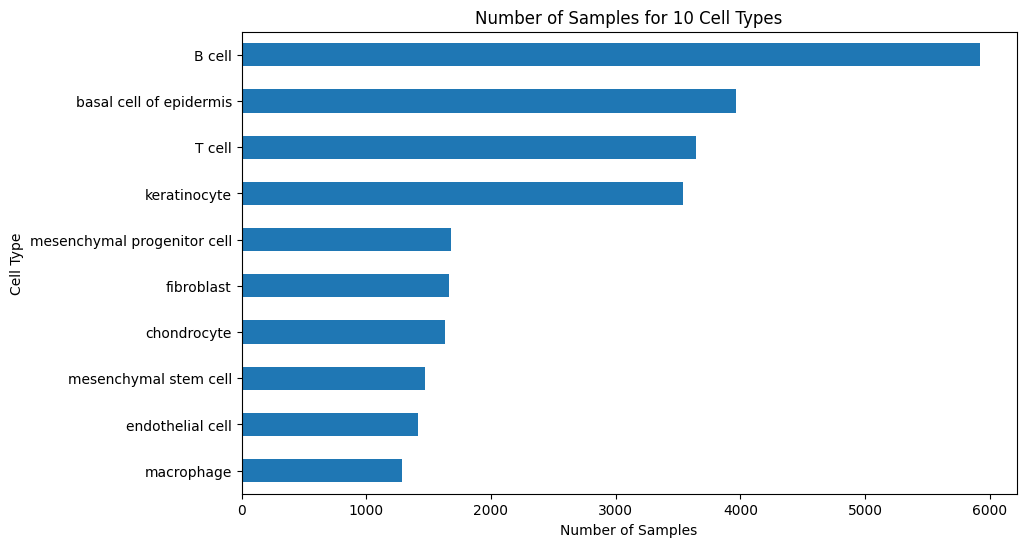

In [3]:
top_10_class_counts = adata_sub.obs['cell_ontology_class'].value_counts().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_10_class_counts.plot(kind='barh')
plt.xlabel('Number of Samples')
plt.ylabel('Cell Type')
plt.title('Number of Samples for 10 Cell Types')
plt.gca().invert_yaxis()
plt.show()

In [4]:
for cell_type, count in top_10_class_counts.items():
    print(f"{cell_type}: {count}")

B cell: 5918
basal cell of epidermis: 3964
T cell: 3643
keratinocyte: 3536
mesenchymal progenitor cell: 1676
fibroblast: 1666
chondrocyte: 1630
mesenchymal stem cell: 1468
endothelial cell: 1418
macrophage: 1290


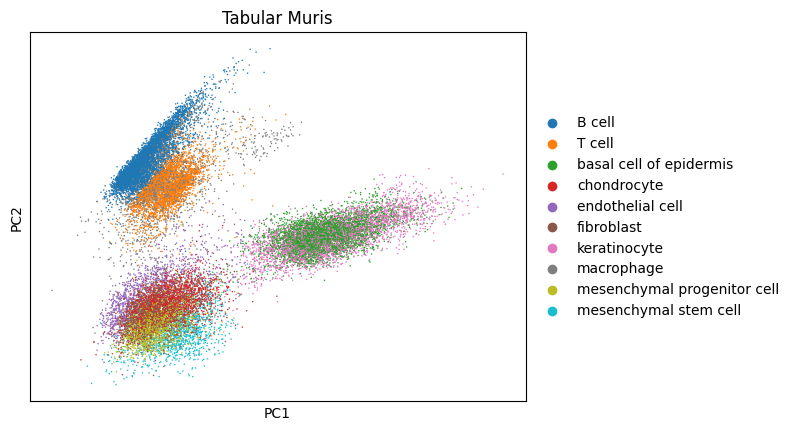

In [5]:
# run pca to select highly variable genes
sc.pp.pca(adata_sub, n_comps=50)
# plot pca
sc.pl.pca(adata_sub, color='cell_ontology_class', title='Tabular Muris',show=True)
# save pca layers
adata_sub.obsm['X_pca'] = adata_sub.obsm['X_pca'].copy()


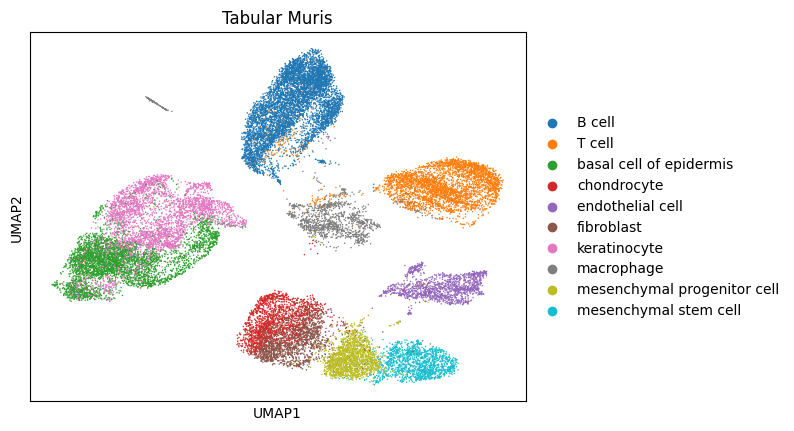

In [6]:
# running umap
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)
# plot umap
sc.pl.umap(adata_sub, color='cell_ontology_class',title='Tabular Muris', show=True)


Interpretation: The data seems cluster together, with B cell, T cell and mesenchymal are in separate cluster. Meanwhile basal and keratino are in the same cluster.

# Implementing Stable Diffusion model

In [3]:
##############################################
# 1. CONFIGURATION 
##############################################

class Config:
    # Data params
    batch_size = 320
    num_timesteps = 1000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model params
    input_dim = None  # set after loading data
    num_classes = None  # set after encoding labels
    hidden_dim = 512
    time_emb_dim = 128
    label_emb_dim = 128
    num_res_blocks = 8
    lr = 1e-3
    max_epochs = 1000

    # Early stopping
    patience = 20

    # Sampling params for log-normal prior
    log_prior_mu = 0
    log_prior_sigma = 1
    eps = 1e-6

    # Noise scheduler
    schedule_type = 'linear'

config = Config()


##############################################
# 2. UTILITIES
##############################################

def compute_pdist(X, Y=None, metric='euclidean'):
    if Y is None:
        Y = X
    return pairwise_distances(X, Y, metric=metric, n_jobs=-1)

def energy_distance(X, Y):
    XX = compute_pdist(X)
    YY = compute_pdist(Y)
    XY = compute_pdist(X, Y)
    return np.sqrt(2*np.mean(XY) - np.mean(XX) - np.mean(YY))

def classwise_energy_distance(real_data, generated_data, labels_encoded, generated_labels):
    energy_distances = []
    print("Energy Distance (per class):")
    for cls in np.unique(labels_encoded):
        real_cls_data = real_data[labels_encoded == cls]
        gen_cls_data = generated_data[generated_labels == cls]

        ed_cls = energy_distance(real_cls_data, gen_cls_data)
        energy_distances.append(ed_cls)

        class_name = le.inverse_transform([cls])[0]
        print(f"Class {class_name}: {ed_cls:.4f}")

    avg_ed = np.mean(energy_distances)
    return avg_ed


def mmd_rbf(X, Y, gamma=None):
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    XX = rbf_kernel(X, X, gamma)
    YY = rbf_kernel(Y, Y, gamma)
    XY = rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def classwise_mmd(real_data, generated_data, labels_encoded, generated_labels):
    mmd_scores = []
    print("MMD (per class):")
    for cls in np.unique(labels_encoded):
        real_cls_data = real_data[labels_encoded == cls]
        gen_cls_data = generated_data[generated_labels == cls]

        mmd_cls = mmd_rbf(real_cls_data, gen_cls_data)
        mmd_scores.append(mmd_cls)

        class_name = le.inverse_transform([cls])[0]
        print(f"Class {class_name}: {mmd_cls:.4f}")

    avg_mmd = np.mean(mmd_scores)
    return avg_mmd


##############################################
# 3. MODEL IMPLEMENTATION
##############################################
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -(torch.log(torch.tensor(10000.0)) / (half_dim - 1)))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            DenseBatchNorm(dim, dim*2,  activation='relu'),
            DenseBatchNorm(dim*2, dim)
        )
    def forward(self, x):
        return x + self.net(x)

class DenseBatchNorm(nn.Module):
    def __init__(self,in_units,out_units,activation=None):
        super().__init__()
        layers = [
            nn.Linear(in_units,out_units),
            nn.BatchNorm1d(out_units)
        ]
        if activation == 'relu':
            layers.append(nn.ReLU())
        self.dense_bn_act = nn.Sequential(*layers)

    def forward(self,x):
        return self.dense_bn_act(x)

class StableDiffusion(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, time_emb_dim=128, label_emb_dim=128, num_res_blocks=4):
        super().__init__()
        self.time_embedding = SinusoidalPosEmb(time_emb_dim)
        self.time_mlp = DenseBatchNorm(time_emb_dim, hidden_dim, activation='relu')
        self.label_embedding = nn.Embedding(num_classes, label_emb_dim)
        self.init_proj = DenseBatchNorm(input_dim + hidden_dim + label_emb_dim,
                                             hidden_dim, activation='relu')
        self.res_blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(num_res_blocks)])
        self.final_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t, labels):
        t_emb = self.time_embedding(t)
        t_emb = self.time_mlp(t_emb)
        label_emb = self.label_embedding(labels)
        h = torch.cat([x, t_emb, label_emb], dim=-1)
        h = self.init_proj(h)
        for block in self.res_blocks:
            h = block(h)
        return self.final_layer(h)


class DiffusionProcess:
    def __init__(self,input_dim,num_timesteps=1000,beta_start=1e-5,
                 beta_end=0.02, schedule_type=config.schedule_type):
        self.input_dim = input_dim
        self.num_timesteps = num_timesteps

        if schedule_type == 'linear':
            beta = torch.linspace(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            beta = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError("Unsupported schedule type. Use 'linear' or 'cosine'.")

        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def _cosine_schedule(self, num_timesteps, s=0.008):
        steps = torch.arange(num_timesteps + 1)/ num_timesteps
        alpha_bar = torch.cos((steps + s) / (1 + s) * torch.pi * 0.5) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        beta = 1 - alpha_bar[1:] / alpha_bar[:-1]
        return torch.clamp(beta, 1e-4, 0.9999)

    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        alpha_bar_t = self.alpha_bar[t]
        noisy_x = torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise
        return noisy_x, noise

class DiffusionProcessLogNormal:
    def __init__(self, input_dim, num_timesteps=1000, beta_start=1e-5, 
                 beta_end=0.02, schedule_type=config.schedule_type, 
                 mu=config.log_prior_mu, 
                 sigma=config.log_prior_sigma,clip_std=4.0):
        self.input_dim = input_dim
        self.mu = mu
        self.sigma = sigma
        self.num_timesteps = num_timesteps

        if schedule_type == 'linear':
            beta = torch.linspace(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            beta = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError("Unsupported schedule type. Use 'linear' or 'cosine'.")

        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.lognormal = torch.distributions.LogNormal(self.mu, self.sigma)
        self.clip_std   = clip_std # to avoid too extreme value caused by log-normal

    def _cosine_schedule(self, num_timesteps, s=0.008):
        steps = torch.arange(num_timesteps + 1)/ num_timesteps
        alpha_bar = torch.cos((steps + s) / (1 + s) * torch.pi * 0.5) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        alpha_bar[-1] =0.0
        beta = 1 - alpha_bar[1:] / alpha_bar[:-1]
        return torch.clamp(beta, 1e-4, 0.9999)

    def add_noise(self, x, t):
        # original data has been log-trans, need to convert back to linear scale
        x_lin = torch.expm1(x)
        log_normal_noise = self.lognormal.sample(x_lin.shape)
        log_normal_noise = torch.clamp(log_normal_noise,
                        self.lognormal.mean - self.clip_std*self.lognormal.stddev,
                        self.lognormal.mean + self.clip_std*self.lognormal.stddev)
        log_normal_noise  = torch.exp(log_normal_noise)

        alpha_bar_t = self.alpha_bar[t]
        noisy_x = torch.sqrt(alpha_bar_t) * x_lin + torch.sqrt(1 - alpha_bar_t) * log_normal_noise

        # convert back to log space
        x_noisy_log = torch.log1p(noisy_x)
        return x_noisy_log, torch.log1p(log_normal_noise)

class DiffusionDataset(Dataset):
    def __init__(self,X,labels,diffusion,num_timesteps):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.diffusion = diffusion
        self.num_timesteps = num_timesteps

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        t = torch.randint(0, self.diffusion.num_timesteps, ()).long()
        label = self.labels[idx]
        x_noisy, noise = self.diffusion.add_noise(x, t)
        return (x_noisy,t,label), noise

def prepare_dataset(X,labels,diffusion,batch_size,num_timesteps=1000):
    dataset = DiffusionDataset(X, labels,diffusion, num_timesteps)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            pin_memory=True)
    return dataloader


class DiffusionDatasetLog(Dataset):
    def __init__(self, X, labels, diffusion, num_timesteps, eps=1e-6):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.diffusion = diffusion
        self.num_timesteps = num_timesteps

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_log = self.X[idx]
        t = torch.randint(0,self.diffusion.num_timesteps, ()).long()
        label = self.labels[idx]
        x_noisy, noise = self.diffusion.add_noise(x_log, t)
        return (x_noisy, t, label), noise

def prepare_dataset_log(X, labels, diffusion, batch_size, num_timesteps=1000):
    dataset = DiffusionDatasetLog(X, labels, diffusion, num_timesteps)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    return dataloader



##############################################
# 4. SAMPLING
##############################################

def sample(models,diffusion,labels,num_samples,device='cuda'):
    if not isinstance(models, list):
        models = [models]

    samples = torch.randn(num_samples, diffusion.input_dim).to(device)

    for t in reversed(range(diffusion.num_timesteps)):
        timestep = torch.full((num_samples,), t, dtype=torch.long).to(device)

        pred_noise = torch.zeros_like(samples).to(device)
        for model in models:
            model.eval()
            with torch.no_grad():
                pred = model(samples, timestep, labels)
            pred_noise += pred
        pred_noise /= len(models)

        alpha_bar_t = diffusion.alpha_bar[t].to(device)
        alpha_bar_prev = diffusion.alpha_bar[t-1].to(device) if t > 0 else torch.tensor(1.0).to(device)
        alpha_t = alpha_bar_t/alpha_bar_prev

        coef = diffusion.beta[t].to(device)/torch.sqrt(1 - alpha_bar_t)

        samples = (samples - coef * pred_noise) / torch.sqrt(alpha_t)
        if t > 0:
            noise = torch.randn_like(samples)
            samples += torch.sqrt(diffusion.beta[t]) * noise

    return samples.cpu().numpy()

def sample_log_normal(model,diffusion,labels,num_samples,device='cuda'):
    
    log_normal_dist = torch.distributions.LogNormal(config.log_prior_mu, config.log_prior_sigma)
    samples_log = log_normal_dist.sample((num_samples, config.input_dim)).to(device)

    for t in reversed(range(diffusion.num_timesteps)):
        timestep = torch.full((num_samples,), t, dtype=torch.long).to(device)
        pred_noise = torch.zeros_like(samples_log).to(device)

        model.eval()
        with torch.no_grad():
            pred = model(samples_log, timestep, labels)
        pred_noise += pred

        alpha_bar_t = diffusion.alpha_bar[t].to(device)
        alpha_bar_prev = diffusion.alpha_bar[t-1].to(device) if t > 0 else torch.tensor(1.0).to(device)
        alpha_t = alpha_bar_t / alpha_bar_prev

        coef = diffusion.beta[t].to(device) / torch.sqrt(1 - alpha_bar_t)

        samples_log = (samples_log - coef * pred_noise) / torch.sqrt(alpha_t)
        if t > 0:
            noise = torch.randn_like(samples_log)
            samples_log += torch.sqrt(diffusion.beta[t]) * noise

    # Put in the range 0-10 to avoid extreme value
    samples_log = samples_log.clamp(min=0, max=10)

    return samples_log


##############################################
# 5. GENERATE SYNTHETIC DATA
##############################################

def generate_synthetic_data(model, diffusion, labels_encoded, num_samples_per_class, device):
    model.eval()
    unique_labels = np.unique(labels_encoded)
    generated_data = []
    generated_labels = []

    for label in unique_labels:
        label_tensor = torch.full((num_samples_per_class,), label, dtype=torch.long).to(device)
        samples = sample(model, diffusion, label_tensor, num_samples_per_class, device=device)
        generated_data.append(samples)
        generated_labels.extend([label] * num_samples_per_class)

    generated_data = np.vstack(generated_data)
    generated_labels = np.array(generated_labels)
    return generated_data, generated_labels

def generate_synthetic_data_log(model, diffusion, labels_encoded, num_samples_per_class, device):
    model.eval()
    unique_labels = np.unique(labels_encoded)
    generated_data = []
    generated_labels = []

    for label in unique_labels:
        label_tensor = torch.full((num_samples_per_class,), label, dtype=torch.long).to(device)
        samples = sample_log_normal(model, diffusion, label_tensor, num_samples_per_class, device=device)
        generated_data.append(samples.cpu().numpy())
        generated_labels.extend([label] * num_samples_per_class)

    generated_data = np.vstack(generated_data)
    generated_labels = np.array(generated_labels)

    return generated_data, generated_labels


##############################################
# 6. TRAINING LOOP
##############################################

def train_loop(config, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    best_val_loss = float('inf')
    trigger_times = 0

    train_losses = []
    val_losses = []

    for epoch in range(config.max_epochs):
        model.train()
        train_loss_accum = 0.0
        num_batches = 0

        for (x_noisy, t, label_batch), noise in train_loader:
            x_noisy = x_noisy.to(config.device)
            t = t.to(config.device)
            label_batch = label_batch.to(config.device)
            noise = noise.to(config.device)

            pred_noise = model(x_noisy, t, label_batch)
            loss = F.mse_loss(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_accum += loss.item()
            num_batches += 1

        avg_train_loss = train_loss_accum / num_batches
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (x_noisy, t, label_batch), noise in val_loader:
                x_noisy = x_noisy.to(config.device)
                t = t.to(config.device)
                label_batch = label_batch.to(config.device)
                noise = noise.to(config.device)

                pred_noise = model(x_noisy, t, label_batch)
                val_loss += F.mse_loss(pred_noise, noise).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{config.max_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= config.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        scheduler.step()


def train_loop_log(config, model, train_loader, val_loader):
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    best_val_loss = float('inf')
    trigger_times = 0

    train_losses = []
    val_losses = []

    for epoch in range(config.max_epochs):
        model.train()
        train_loss_accum = 0.0
        num_batches = 0

        for (x_noisy, t, label_batch), noise in train_loader:
            x_noisy = x_noisy.to(config.device)
            t = t.to(config.device)
            label_batch = label_batch.to(config.device)
            noise = noise.to(config.device)

        
            pred_noise = model(x_noisy, t, label_batch)

        
            loss = F.mse_loss(pred_noise, noise)
       

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            train_loss_accum += loss.item()
            num_batches += 1

        avg_train_loss = train_loss_accum / num_batches
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (x_noisy, t, label_batch), noise in val_loader:
                x_noisy = x_noisy.to(config.device)
                t = t.to(config.device)
                label_batch = label_batch.to(config.device)
                noise = noise.to(config.device)

                pred_noise = model(x_noisy, t, label_batch)

                val_loss += F.mse_loss(pred_noise, noise).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{config.max_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= config.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        scheduler.step()


In [4]:
# Convert sparse matrix to dense
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()

labels = adata_sub.obs['cell_ontology_class'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# parameter for config
config.input_dim = X.shape[1]
config.num_classes = len(np.unique(labels_encoded))

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

# Training for normal distribution prior

In [5]:
if __name__ == "__main__":
    # Initialize diffusion process (normal prior)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    diffusion = DiffusionProcess(config.input_dim,
                                 num_timesteps=config.num_timesteps,
                                 schedule_type='linear')
    train_loader = prepare_dataset(X_train, y_train, diffusion, batch_size=config.batch_size)
    val_loader   = prepare_dataset(X_val,   y_val,   diffusion, batch_size=config.batch_size)

    # Initialize model
    model = StableDiffusion(
        input_dim=config.input_dim,
        num_classes=config.num_classes,
        hidden_dim=config.hidden_dim,
        time_emb_dim=config.time_emb_dim,
        label_emb_dim=config.label_emb_dim,
        num_res_blocks=config.num_res_blocks
    ).to(config.device)

    # Train with normal prior data preparation
    train_loop(
    config=config,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader)

    # Save the trained model weights
    torch.save(model.state_dict(), './weight/stable_diffusion_normal_prior.pth')
    print("Model trained and saved with normal prior.")

    # Load your trained model weights (normal prior model)
    model.load_state_dict(torch.load('./weight/stable_diffusion_normal_prior.pth', map_location=device))
    model.eval()

    # Generate synthetic data per class
    num_samples_per_class = 5000
    generated_data_normal, generated_labels_normal = generate_synthetic_data(model, diffusion, labels_encoded, num_samples_per_class, device)



Epoch 1/1000 - Train Loss: 1.150874 - Val Loss: 0.686540
Epoch 2/1000 - Train Loss: 0.510320 - Val Loss: 0.387973
Epoch 3/1000 - Train Loss: 0.330856 - Val Loss: 0.305269


Epoch 4/1000 - Train Loss: 0.276616 - Val Loss: 0.269423
Epoch 5/1000 - Train Loss: 0.251680 - Val Loss: 0.252945
Epoch 6/1000 - Train Loss: 0.234174 - Val Loss: 0.238719
Epoch 7/1000 - Train Loss: 0.227891 - Val Loss: 0.230016
Epoch 8/1000 - Train Loss: 0.214663 - Val Loss: 0.243609
Epoch 9/1000 - Train Loss: 0.213201 - Val Loss: 0.230282
Epoch 10/1000 - Train Loss: 0.201320 - Val Loss: 0.215678
Epoch 11/1000 - Train Loss: 0.194866 - Val Loss: 0.205337
Epoch 12/1000 - Train Loss: 0.190549 - Val Loss: 0.191853
Epoch 13/1000 - Train Loss: 0.193908 - Val Loss: 0.196553
Epoch 14/1000 - Train Loss: 0.186696 - Val Loss: 0.201974
Epoch 15/1000 - Train Loss: 0.186992 - Val Loss: 0.197313
Epoch 16/1000 - Train Loss: 0.188229 - Val Loss: 0.205519
Epoch 17/1000 - Train Loss: 0.188788 - Val Loss: 0.198330
Epoch 18/1000 - Train Loss: 0.179572 - Val Loss: 0.196901
Epoch 19/1000 - Train Loss: 0.182157 - Val Loss: 0.194275
Epoch 20/1000 - Train Loss: 0.185534 - Val Loss: 0.199694
Epoch 21/1000 - Trai

In [6]:
classwise_energy_distance(real_data=X, generated_data=generated_data_normal, labels_encoded=labels_encoded, generated_labels=generated_labels_normal)


Energy Distance (per class):


Class B cell: 0.2471
Class T cell: 0.2862
Class basal cell of epidermis: 0.3145
Class chondrocyte: 0.2274
Class endothelial cell: 0.2209
Class fibroblast: 0.2112
Class keratinocyte: 0.2452
Class macrophage: 0.3797
Class mesenchymal progenitor cell: 0.2456
Class mesenchymal stem cell: 0.2746


0.2652348403672227

In [7]:
classwise_mmd(real_data=X, generated_data=generated_data_normal, labels_encoded=labels_encoded, generated_labels=generated_labels_normal)

MMD (per class):
Class B cell: 0.0032
Class T cell: 0.0045
Class basal cell of epidermis: 0.0093
Class chondrocyte: 0.0040
Class endothelial cell: 0.0044
Class fibroblast: 0.0035
Class keratinocyte: 0.0050
Class macrophage: 0.0111
Class mesenchymal progenitor cell: 0.0049
Class mesenchymal stem cell: 0.0068


0.005668443441390991

# Plotting the generated and real data

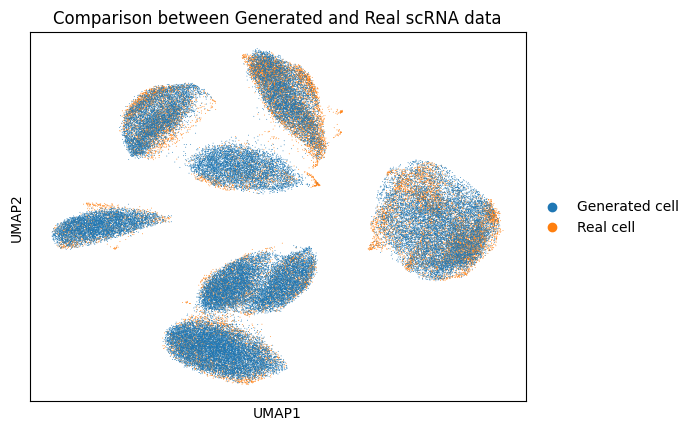

In [8]:
adata_gen = ad.AnnData(X=generated_data_normal,var=adata_sub.var.copy())
adata_gen.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    generated_labels_normal,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_gen.obs['source'] = 'Generated cell'
adata_sub.obs['source'] = 'Real cell'

adata_plot = ad.concat(
    [adata_sub,adata_gen],
    join='outer',
    label='batch',
    keys=['real','gen'])

sc.pp.pca(adata_plot, n_comps=50)
sc.pp.neighbors(adata_plot)
sc.tl.umap(adata_plot)

sc.pl.umap(
    adata_plot,
    color='source',
    title = 'Comparison between Generated and Real scRNA data',
    
)



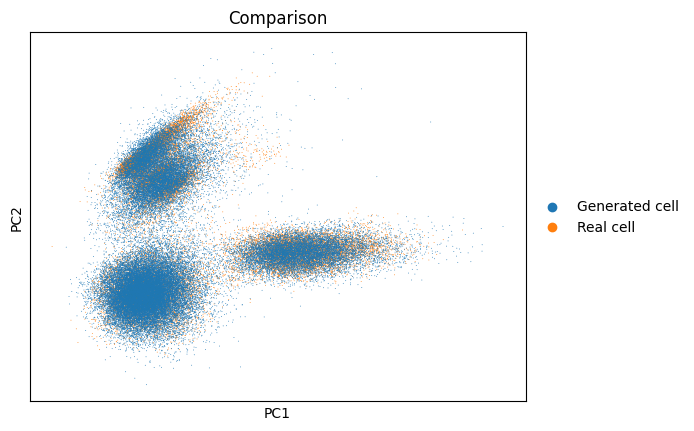

In [9]:
sc.pp.pca(adata_plot, n_comps=50)
sc.pl.pca(adata_plot, color='source', title='Comparison',show=True)

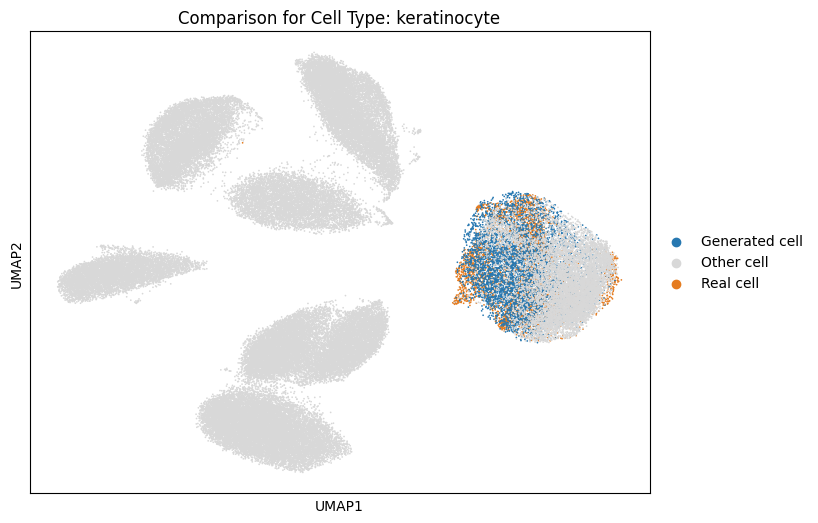

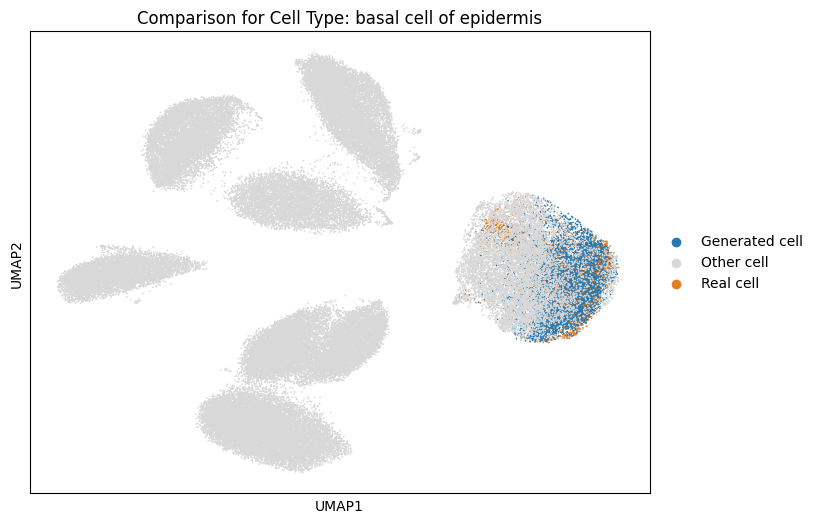

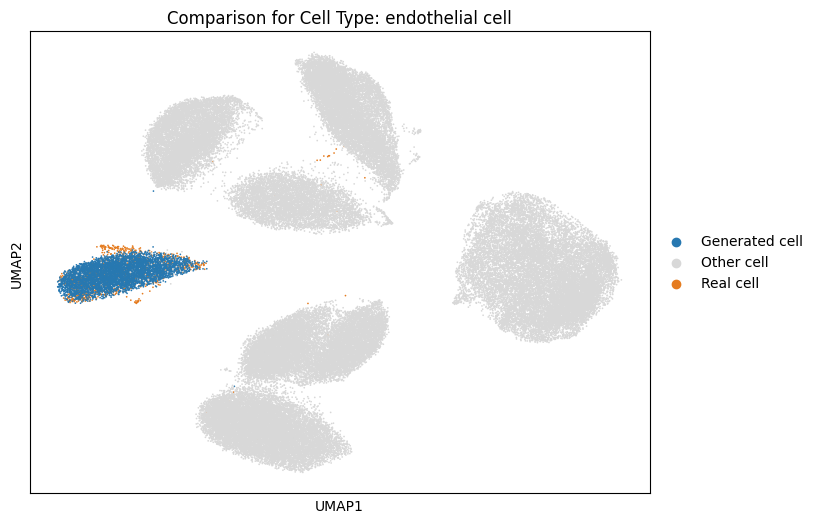

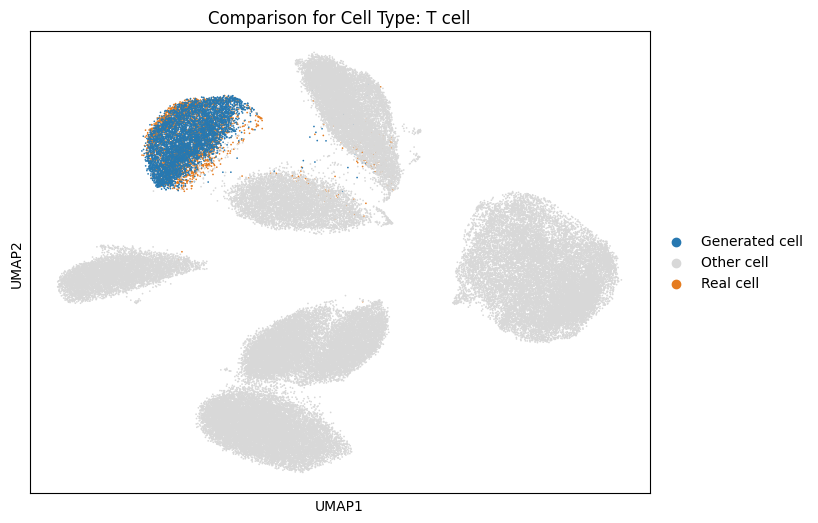

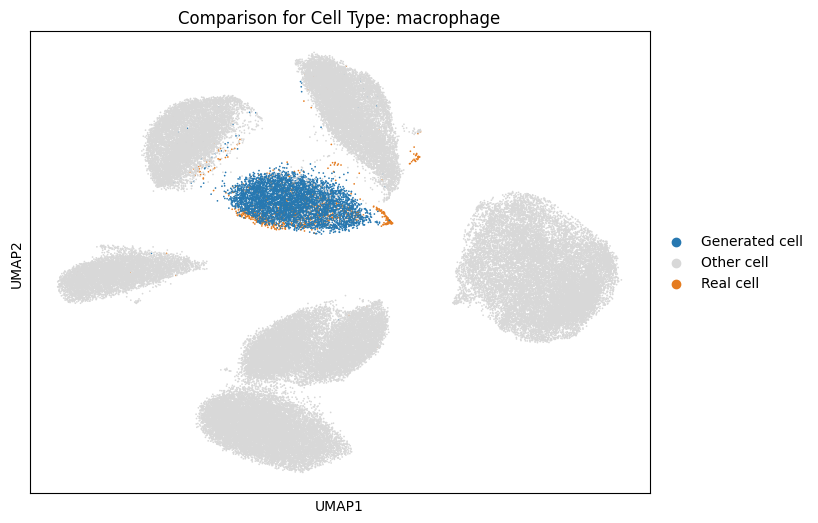

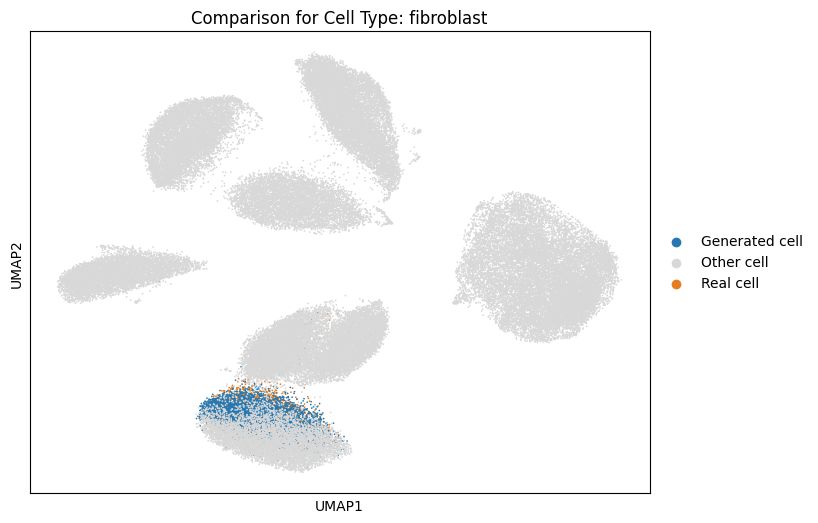

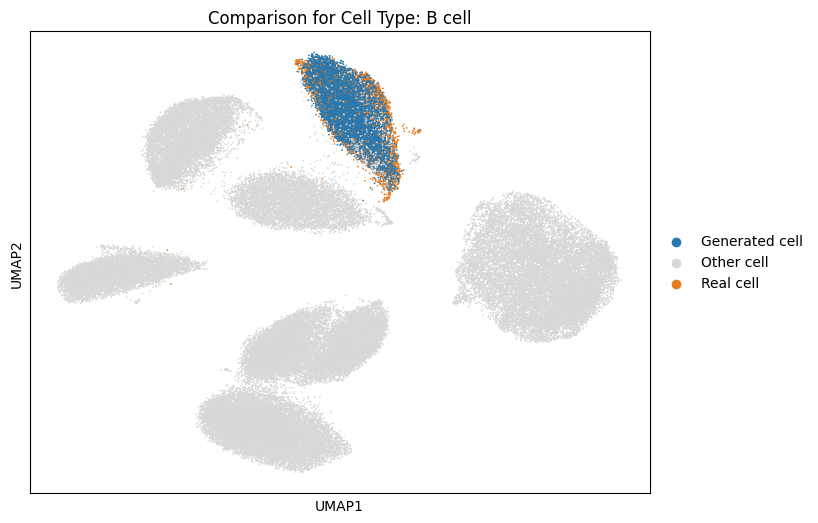

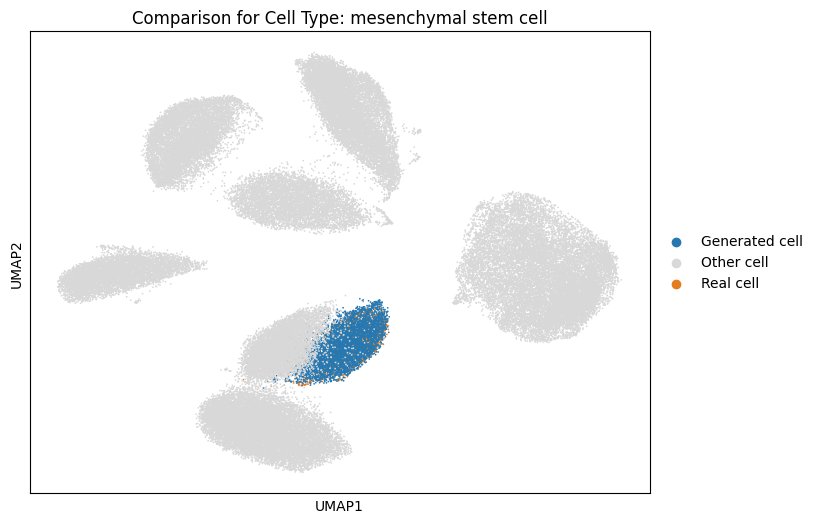

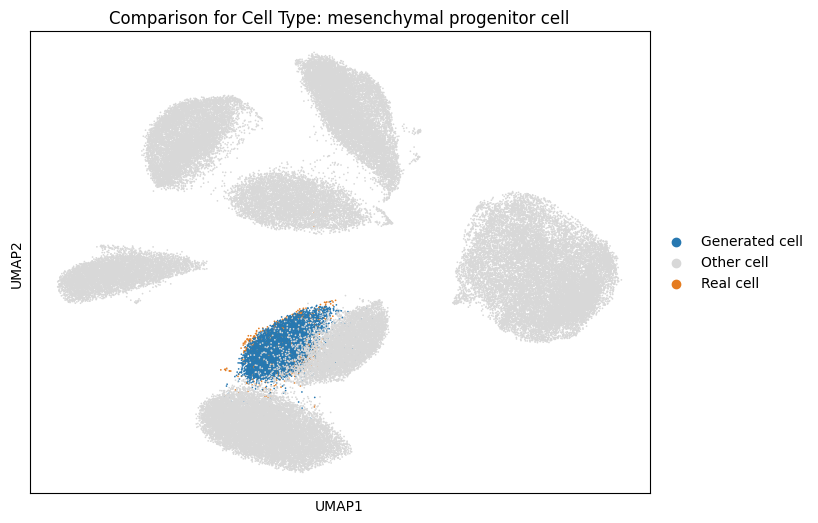

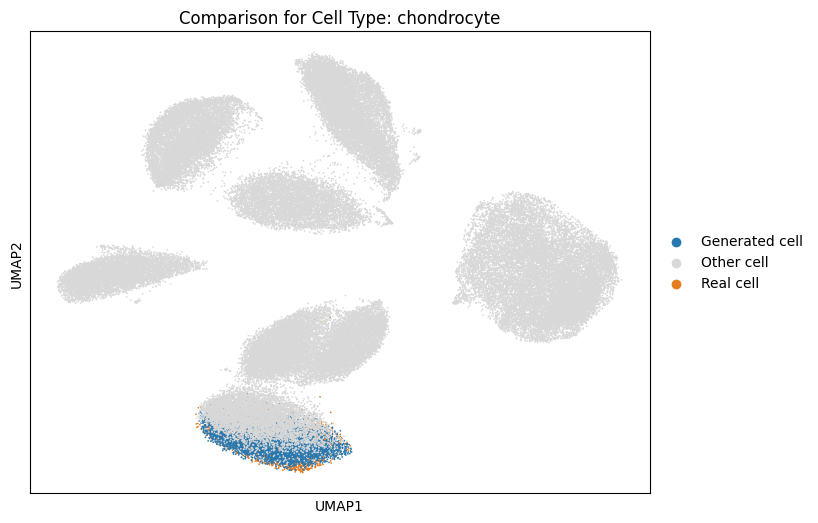

In [10]:
celltypes = adata_plot.obs['cell_ontology_class'].unique()
custom_palette = {
    'Real cell': '#e57c20',       
    'Generated cell': '#2778b1', 
    'Other cell': '#d8d8d8'     
}
for celltype in celltypes:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Filter data for the current cell type (plot only real and generated of this type)
    subset = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype]
    
    # Create a mask for other cell types (all data except current cell type)
    other_cells = adata_plot[adata_plot.obs['cell_ontology_class'] != celltype].copy()
    other_cells.obs['source'] = 'Other cell'  # Label other cells as 'Other cell'
    
    # Combine the current subset (real + generated) and 'Other' cells
    combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)
    
    # Plot UMAP for the current cell type, highlighting real and generated cells as well as other cells in black
    sc.pl.umap(combined_data, color='source', size=6, title=f'Comparison for Cell Type: {celltype}', ax=ax,palette=custom_palette)
    
    # Show the plot
    plt.show()

# Training for log-normal distribution prior

In [11]:
# Convert sparse matrix to dense
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()

labels = adata_sub.obs['cell_ontology_class'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# parameter for config
config.input_dim = X.shape[1]
config.num_classes = len(np.unique(labels_encoded))

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

In [12]:
if __name__ == "__main__":
    # Initialize diffusion process (normal prior)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    diffusion = DiffusionProcessLogNormal(config.input_dim,
                                 num_timesteps=config.num_timesteps,
                                 schedule_type='cosine')
    train_loader = prepare_dataset_log(X_train, y_train, diffusion, batch_size=config.batch_size)
    val_loader   = prepare_dataset_log(X_val,   y_val,   diffusion, batch_size=config.batch_size)

    # Initialize model
    model = StableDiffusion(
        input_dim=config.input_dim,
        num_classes=config.num_classes,
        hidden_dim=config.hidden_dim,
        time_emb_dim=config.time_emb_dim,
        label_emb_dim=config.label_emb_dim,
        num_res_blocks=config.num_res_blocks
    ).to(config.device)

    # Train with normal prior data preparation
    train_loop_log(
    config=config,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader)

    # Save the trained model weights
    torch.save(model.state_dict(), './weight/stable_diffusion_log_prior.pth')
    print("Model trained and saved with log prior.")

    # Load your trained model weights (normal prior model)
    model.load_state_dict(torch.load('./weight/stable_diffusion_log_prior.pth', map_location=device))
    model.eval()

    # Generate synthetic data per class
    num_samples_per_class = 5000
    generated_data_log, generated_labels_log = generate_synthetic_data_log(model, diffusion, labels_encoded, num_samples_per_class,device)



Epoch 1/1000 - Train Loss: 4.432404 - Val Loss: 2.320772


Epoch 2/1000 - Train Loss: 1.700292 - Val Loss: 1.402022
Epoch 3/1000 - Train Loss: 1.244862 - Val Loss: 1.114422
Epoch 4/1000 - Train Loss: 1.019076 - Val Loss: 0.936472
Epoch 5/1000 - Train Loss: 0.897437 - Val Loss: 0.846280
Epoch 6/1000 - Train Loss: 0.823572 - Val Loss: 0.785758
Epoch 7/1000 - Train Loss: 0.767196 - Val Loss: 0.757477
Epoch 8/1000 - Train Loss: 0.730757 - Val Loss: 0.709934
Epoch 9/1000 - Train Loss: 0.700212 - Val Loss: 0.683603
Epoch 10/1000 - Train Loss: 0.679314 - Val Loss: 0.665470
Epoch 11/1000 - Train Loss: 0.653598 - Val Loss: 0.642181
Epoch 12/1000 - Train Loss: 0.644535 - Val Loss: 0.629441
Epoch 13/1000 - Train Loss: 0.632974 - Val Loss: 0.628955
Epoch 14/1000 - Train Loss: 0.623704 - Val Loss: 0.601972
Epoch 15/1000 - Train Loss: 0.615637 - Val Loss: 0.605084
Epoch 16/1000 - Train Loss: 0.608446 - Val Loss: 0.596183
Epoch 17/1000 - Train Loss: 0.600988 - Val Loss: 0.593563
Epoch 18/1000 - Train Loss: 0.596048 - Val Loss: 0.586505
Epoch 19/1000 - Train 

In [13]:
classwise_energy_distance(real_data=X, generated_data=generated_data_log, labels_encoded=labels_encoded, generated_labels=generated_labels_log)

Energy Distance (per class):
Class B cell: 7.6598
Class T cell: 7.7634
Class basal cell of epidermis: 7.9100
Class chondrocyte: 7.5654
Class endothelial cell: 7.2775
Class fibroblast: 7.4566
Class keratinocyte: 7.7107
Class macrophage: 7.6089
Class mesenchymal progenitor cell: 7.5846
Class mesenchymal stem cell: 7.7088


7.6245700543460755

In [14]:
classwise_mmd(real_data=X, generated_data=generated_data_log, labels_encoded=labels_encoded, generated_labels=generated_labels_log)

MMD (per class):
Class B cell: 0.8154
Class T cell: 0.8042
Class basal cell of epidermis: 0.6534
Class chondrocyte: 0.6796
Class endothelial cell: 0.5815
Class fibroblast: 0.6867
Class keratinocyte: 0.5331
Class macrophage: 0.4613
Class mesenchymal progenitor cell: 0.7500
Class mesenchymal stem cell: 0.6394


0.6604751113502629

In [15]:
generated_data_log.min()

0.0

In [16]:
generated_data_log.max()

10.0

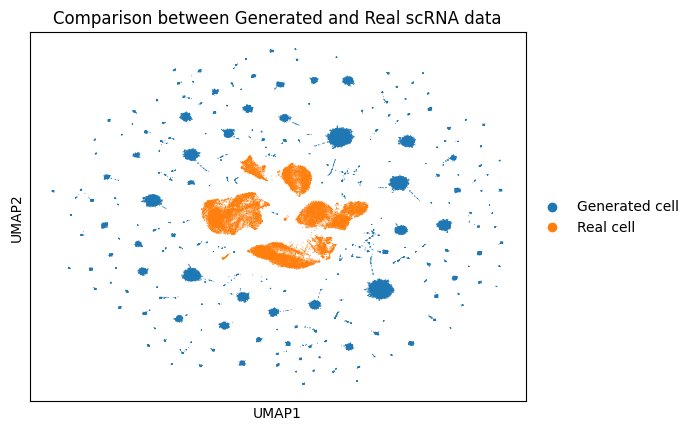

In [17]:
adata_gen_log = ad.AnnData(X=generated_data_log,var=adata_sub.var.copy())
adata_gen_log.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    generated_labels_log,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_gen_log.obs['source'] = 'Generated cell'
adata_sub.obs['source'] = 'Real cell'

adata_plot_log = ad.concat(
    [adata_sub,adata_gen_log],
    join='outer',
    label='batch',
    keys=['real','gen'])

sc.pp.pca(adata_plot_log, n_comps=50)
sc.pp.neighbors(adata_plot_log)
sc.tl.umap(adata_plot_log)

sc.pl.umap(
    adata_plot_log,
    color='source',
    title = 'Comparison between Generated and Real scRNA data',
    
)




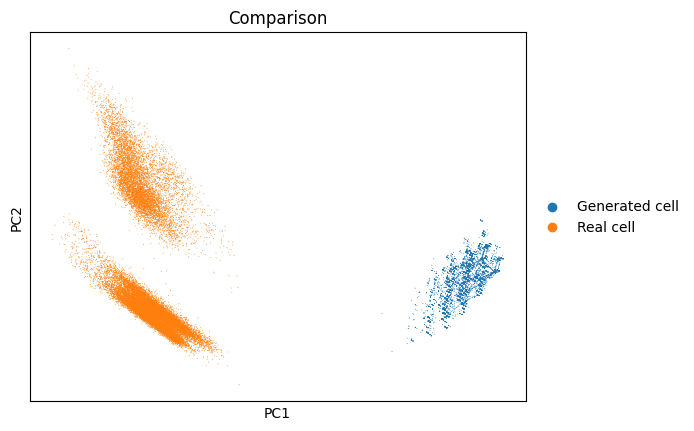

In [18]:
sc.pp.pca(adata_plot_log, n_comps=50)
sc.pl.pca(adata_plot_log, color='source', title='Comparison',show=True)

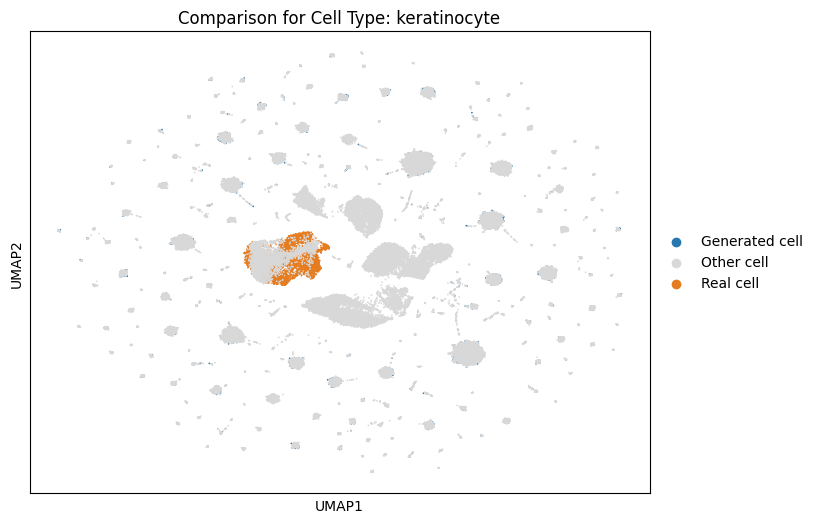

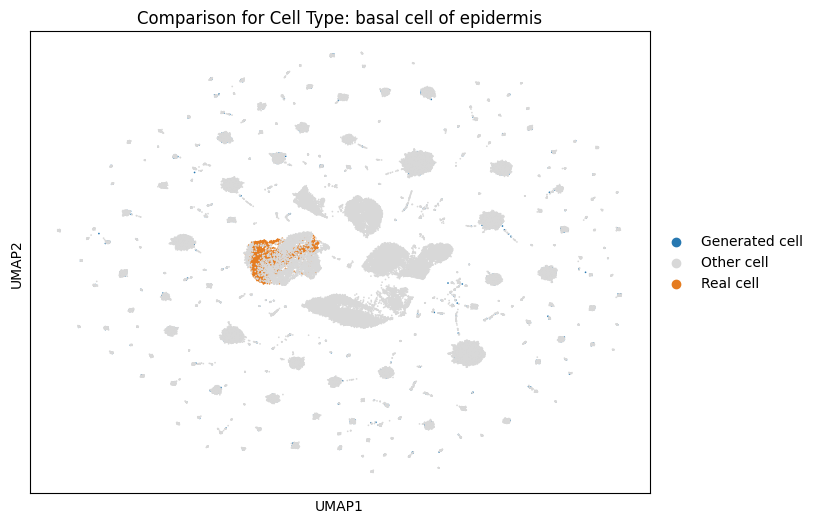

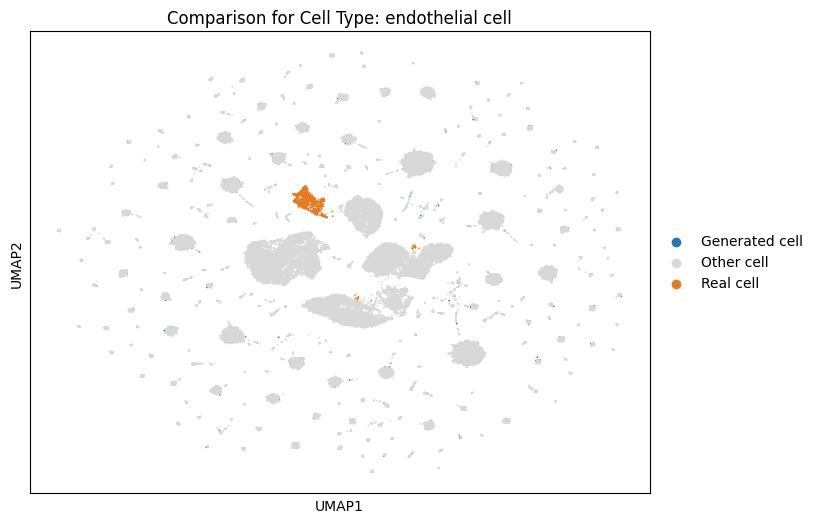

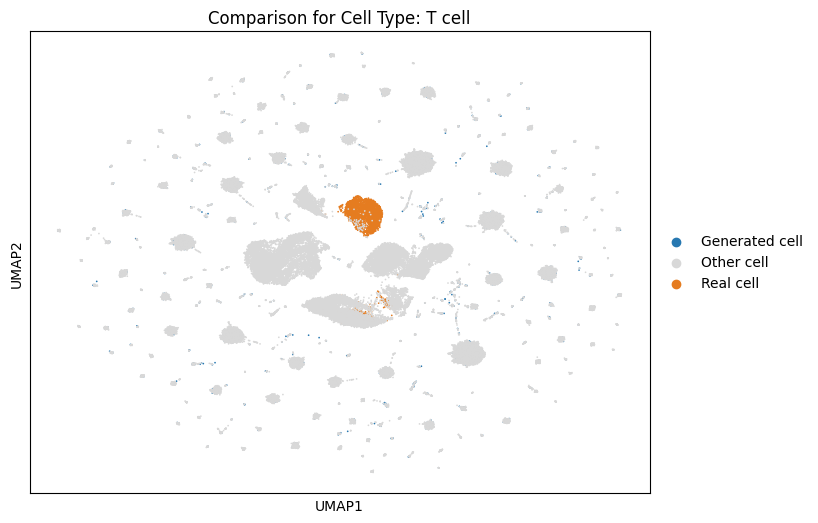

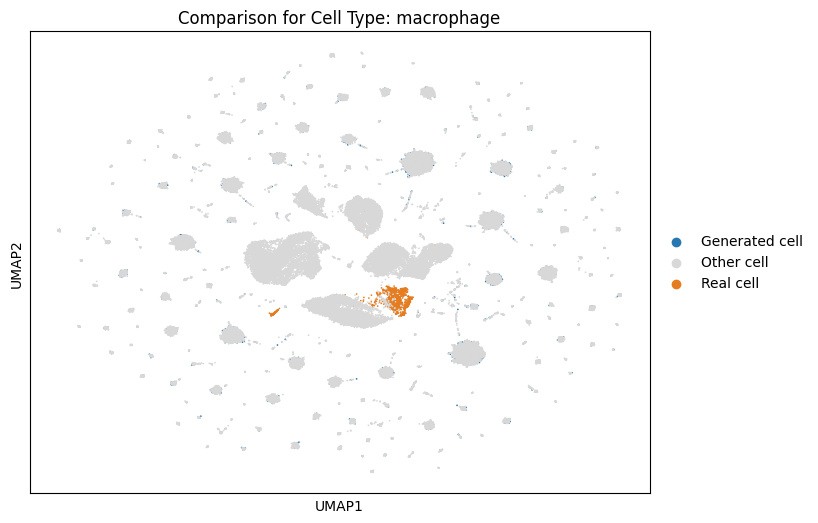

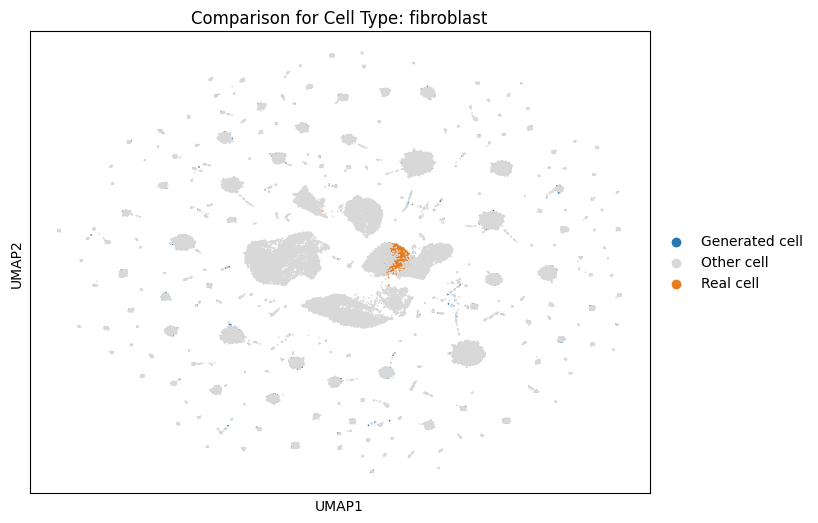

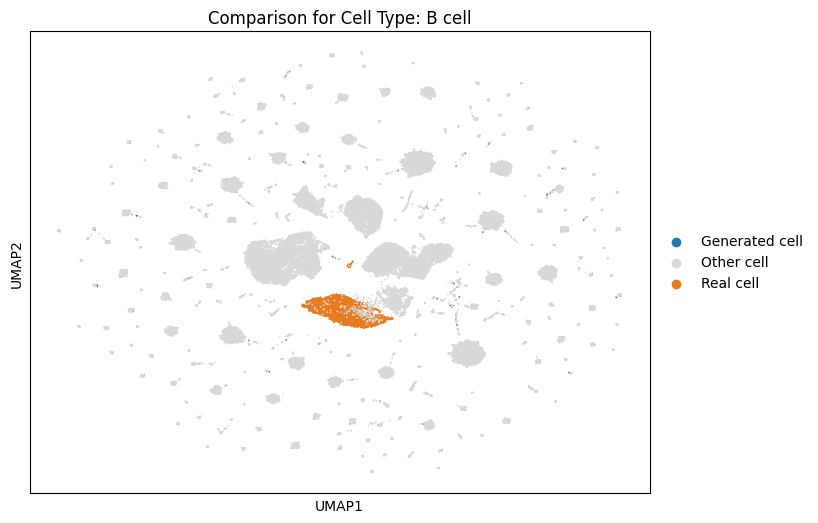

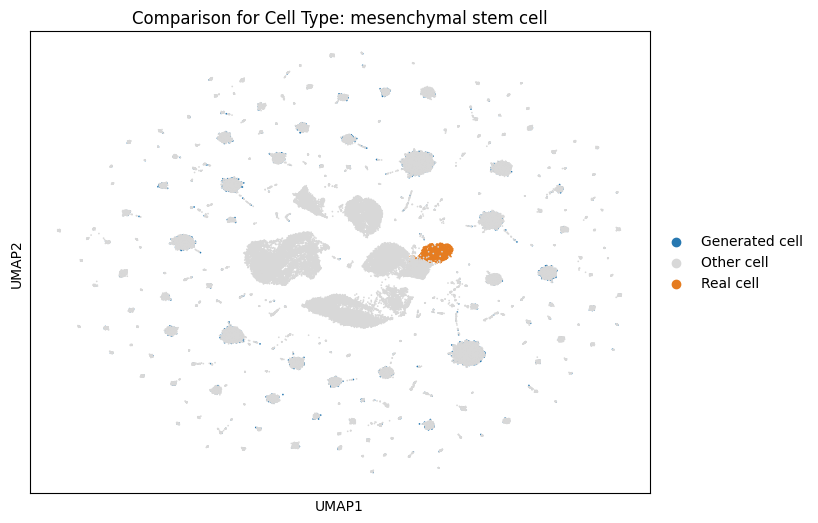

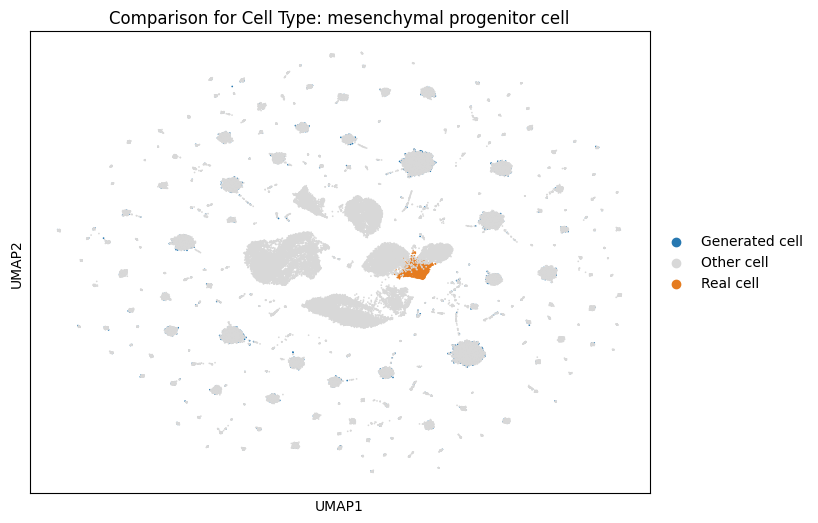

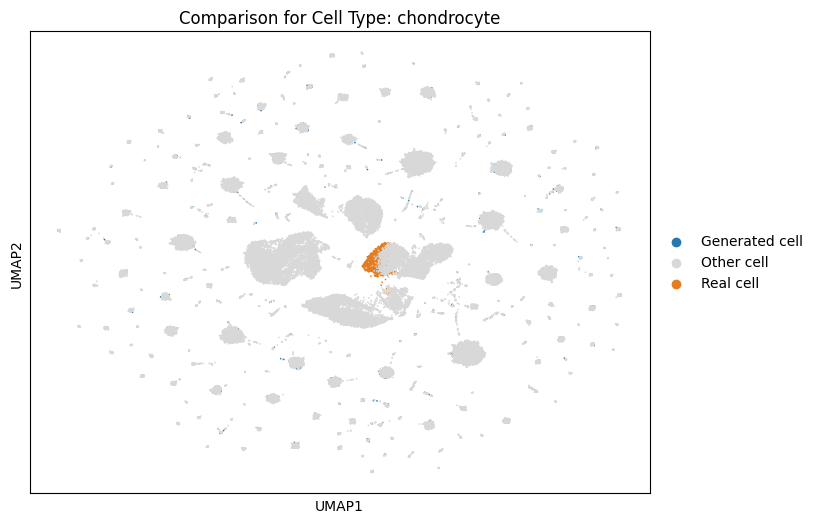

In [19]:
celltypes = adata_plot_log.obs['cell_ontology_class'].unique()
custom_palette = {
    'Real cell': '#e57c20',       
    'Generated cell': '#2778b1', 
    'Other cell': '#d8d8d8'     
}
for celltype in celltypes:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Filter data for the current cell type (plot only real and generated of this type)
    subset = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype]
    
    # Create a mask for other cell types (all data except current cell type)
    other_cells = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] != celltype].copy()
    other_cells.obs['source'] = 'Other cell'  # Label other cells as 'Other cell'
    
    # Combine the current subset (real + generated) and 'Other' cells
    combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)
    
    # Plot UMAP for the current cell type, highlighting real and generated cells as well as other cells in black
    sc.pl.umap(combined_data, color='source', size=6, title=f'Comparison for Cell Type: {celltype}', ax=ax,palette=custom_palette)
    
    # Show the plot
    plt.show()

# Plot the noise process

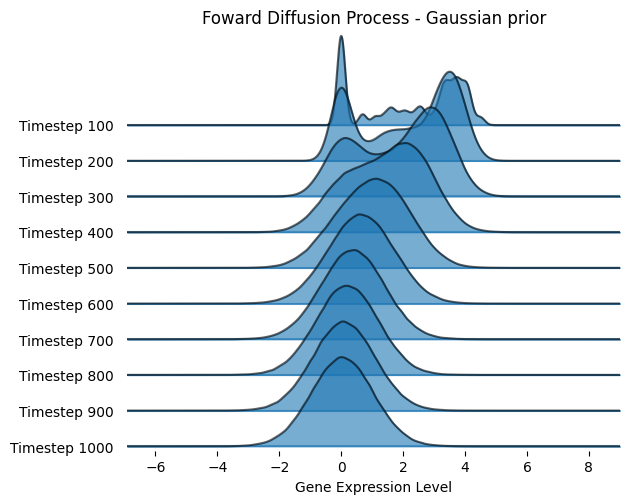

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from joypy import joyplot

X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()
x0 = torch.tensor(X[0], dtype=torch.float32)

diff = DiffusionProcess(input_dim=x0.shape[0])
n_draws   = 2000

all_xt = []
for t in range(0,config.num_timesteps,100):
    xt_samples = []
    t_tensor   = torch.tensor([t], dtype=torch.long)
    for _ in range(n_draws):
        # add_noise works on a single sample here
        x_t, _ = diff.add_noise(x0, t_tensor)
        xt_samples.append(x_t.numpy())
    all_xt.append(np.concatenate(xt_samples))  # flatten to 1D

# 5) joyplot them exactly like before
fig, axes = joyplot(
    all_xt,
    labels=[f"Timestep {(t+1)*100}" for t in range(len(all_xt))],  # Labels for each timestep
    grid=False,
    ylim='auto',
    alpha=0.6
)

# Customize the plot with title and labels
plt.title('Foward Diffusion Process - Gaussian prior')
plt.xlabel('Gene Expression Level')
plt.ylabel('Density')
plt.show()




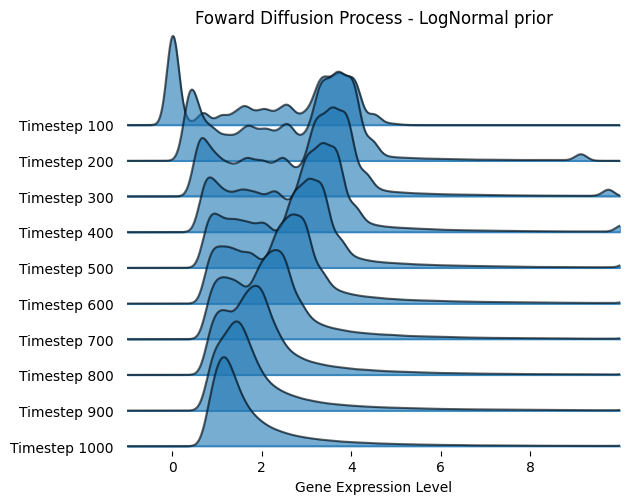

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from joypy import joyplot

X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()
x0 = torch.tensor(X[0], dtype=torch.float32)

diff = DiffusionProcessLogNormal(input_dim=x0.shape[0])
n_draws   = 2000

all_xt = []
for t in range(0,config.num_timesteps,100):
    xt_samples = []
    t_tensor   = torch.tensor([t], dtype=torch.long)
    for _ in range(n_draws):
        # add_noise works on a single sample here
        x_t, _ = diff.add_noise(x0, t_tensor)
        xt_samples.append(x_t.numpy())
    all_xt.append(np.concatenate(xt_samples))  # flatten to 1D

# 5) joyplot them exactly like before
fig, axes = joyplot(
    all_xt,
    labels=[f"Timestep {(t+1)*100}" for t in range(len(all_xt))],  # Labels for each timestep
    grid=False,
    ylim='auto',
    x_range=(-1,10),
    alpha=0.6
)

# Customize the plot with title and labels
plt.title('Foward Diffusion Process - LogNormal prior')
plt.xlabel('Gene Expression Level')
plt.ylabel('Density')
plt.show()


